# Contraste de Grupos

In [54]:
install.packages(c("tidyverse", "rstatix", "skimr", "e1071"))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘proxy’




In [14]:
library(haven)

df = read_spss("https://github.com/renatoparedes/EstadisticaYPsicologiaMatematica/raw/main/INEE/Clase7_BaseContrasteDeGrupos.sav")
df

Código,Sexo,Pretest,Postest
<chr>,<dbl+lbl>,<dbl>,<dbl>
001,1,30,27
002,2,24,23
003,2,22,18
004,1,30,18
005,2,26,20
006,1,24,25
007,1,24,21
008,1,22,17
009,2,18,18


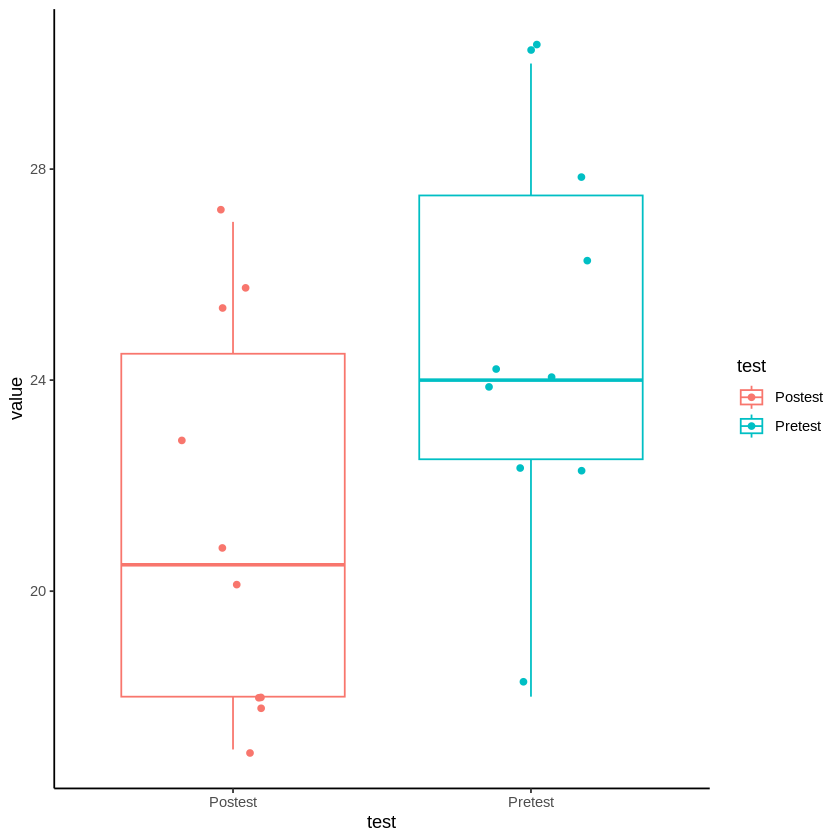

In [21]:
library(tidyverse)

df %>%
  pivot_longer(-c(1:2), names_to = "test", values_to = "value") -> dt

p <- ggplot(dt, aes(x = test, y = value, color = test))

p + geom_boxplot() + geom_jitter(width = .2) + theme_classic()

# Descripción de los datos

In [40]:
library(skimr)

dt %>% select(test, value) %>% group_by(test) %>% skim() %>% tibble()

skim_type,skim_variable,test,n_missing,complete_rate,numeric.mean,numeric.sd,numeric.p0,numeric.p25,numeric.p50,numeric.p75,numeric.p100,numeric.hist
<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
numeric,value,Postest,0,1,21.3,3.713339,17,18.0,20.5,24.5,27,▇▃▂▂▃
numeric,value,Pretest,0,1,24.8,3.794733,18,22.5,24.0,27.5,30,▂▅▇▂▇


# Análisis de Normalidad

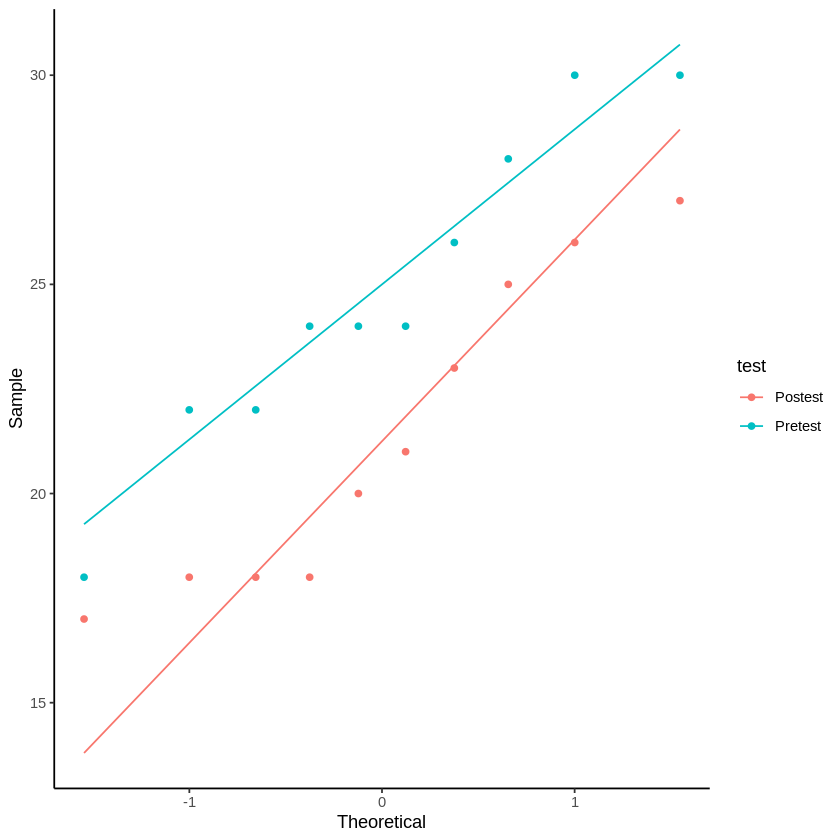

In [52]:
p <- ggplot(dt, aes(sample = value, color = test))

p + stat_qq() + stat_qq_line() + theme_classic() + labs(x = "Theoretical", y = "Sample")

In [53]:
library(rstatix)

dt %>%
  group_by(test) %>%
  shapiro_test(value)


Attaching package: ‘rstatix’


The following object is masked from ‘package:stats’:

    filter




test,variable,statistic,p
<chr>,<chr>,<dbl>,<dbl>
Postest,value,0.8923593,0.1802463
Pretest,value,0.9418100,0.5733240


In [101]:
library(e1071)

dt %>%
    select(test, value) %>%
    nest_by(test) %>%
    mutate(curtosis = map(data, ~ kurtosis(.x, type = 2)),
           asimetría = map(data, ~ skewness(.x, type = 2))) %>%
    reframe(curtosis, asimetría)

test,curtosis,asimetría
<chr>,<dbl>,<dbl>
Postest,-1.5385768,0.4205497
Pretest,-0.3064374,-0.1122413


Ambas distribuciones se aproximan a la distribución normal. Por tanto, corresponde usar índice paramétrico t para dos muestras relacionadas.

# Contraste de muestras relacionadas

In [83]:
library(rstatix)

dt %>%
  t_test(value ~ test, paired = T)

,.y.,group1,group2,n1,n2,statistic,df,p
,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>
1,value,Postest,Pretest,10,10,-3,9,0.015


De acuerdo al análisis de contraste se observa una diferencia significativa en el puntaje de ansiedad entre la evaluación pre-test y la de post-test, t(9)=3.00, p=.02. De manera específica, se observa una reducción en ansiedad pre-test (M=24.8, DE=3.80) al post-test (M=21.3, DE=3.71) reportada por las/los participantes.

# Contraste de muestras independientes

In [84]:
df_ind = df %>% select(Sexo, Postest) %>% mutate(Sexo = as_factor(Sexo))
df_ind

Sexo,Postest
<fct>,<dbl>
Mujer,27
Hombre,23
Hombre,18
Mujer,18
Hombre,20
Mujer,25
Mujer,21
Mujer,17
Hombre,18


In [87]:
df_ind %>%
  group_by(Sexo) %>%
  skim() %>%
  tibble()

skim_type,skim_variable,Sexo,n_missing,complete_rate,numeric.mean,numeric.sd,numeric.p0,numeric.p25,numeric.p50,numeric.p75,numeric.p100,numeric.hist
<chr>,<chr>,<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
numeric,Postest,Mujer,0,1,22.33333,4.273952,17,18.75,23,25.75,27,▇▃▁▃▇
numeric,Postest,Hombre,0,1,19.75000,2.362908,18,18.00,19,20.75,23,▇▃▁▁▃


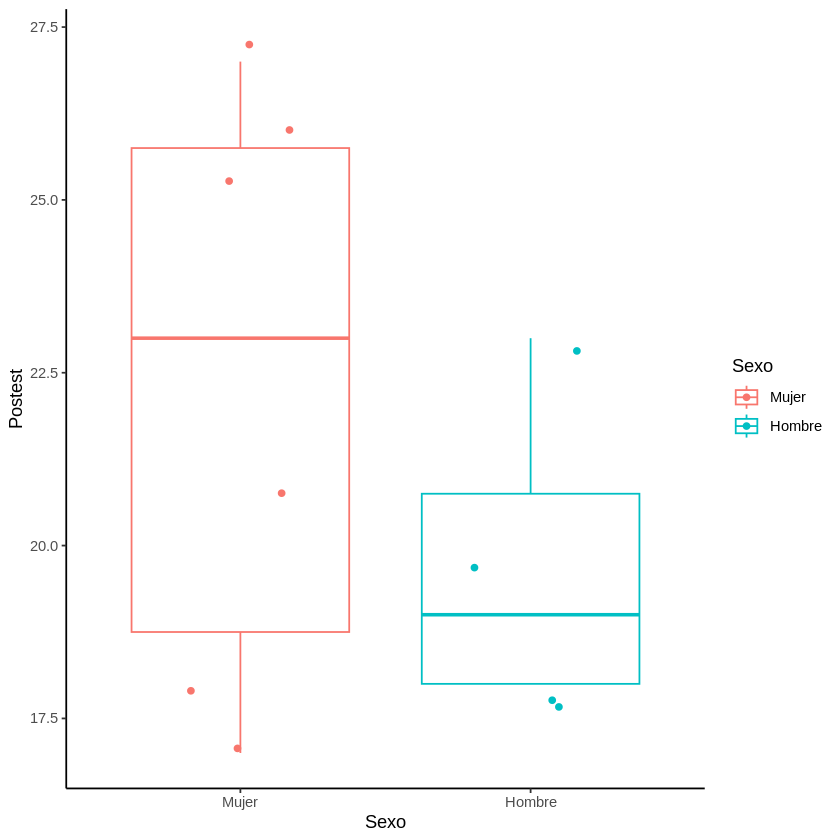

In [88]:
p <- ggplot(df_ind, aes(x = Sexo, y = Postest, color = Sexo))

p + geom_boxplot() + geom_jitter(width = .2) + theme_classic()

In [89]:
df_ind %>%
  group_by(Sexo) %>%
  shapiro_test(Postest)

Sexo,variable,statistic,p
<fct>,<chr>,<dbl>,<dbl>
Mujer,Postest,0.8924716,0.3313410
Hombre,Postest,0.8480787,0.2199986


Ambas distribuciones se aproximan a la normalidad. Corresponde usar índice paramétrico t para dos muestras independientes.

In [90]:
df_ind %>%
  levene_test(Postest ~ Sexo)

df1,df2,statistic,p
<int>,<int>,<dbl>,<dbl>
1,8,3.512033,0.09779746


El resultado de la prueba de Levene no es significativo, F=4.65, p=.06, por lo que se asumen varianzas iguales entre el grupo de mujeres y el de hombres.

In [93]:
df_ind %>% t_test(Postest ~ Sexo, var.equal = T)

df_ind %>% cohens_d(Postest ~ Sexo, var.equal = T)

,.y.,group1,group2,n1,n2,statistic,df,p
,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>
1,Postest,Mujer,Hombre,6,4,1.088809,8,0.308


,.y.,group1,group2,effsize,n1,n2,magnitude
,<chr>,<chr>,<chr>,<dbl>,<int>,<int>,<ord>
1,Postest,Mujer,Hombre,0.7028232,6,4,moderate


No se observa una diferencia en ansiedad según el sexo de las y los participantes, t(8)=1.09, p=.31. Los puntajes de ansiedad reportados no difieren entre mujeres (M=22.33, DE=4.27) y hombres (M=19.75, DE=2.36).

# Contraste global

In [95]:
df2 = haven::read_spss("https://github.com/renatoparedes/EstadisticaYPsicologiaMatematica/raw/main/INEE/Clase6_BaseEstadisticaDescriptiva.sav")
df2

Código,Sexo,Edad,EstadoCivil,NúmHermanos,OrdenHermanos,Religión,LugarNac,IntFamiliar,Instrucción,EstLaboral,EPA1,EPA2,EPA3,EPA4,EPA5,EPA6
<chr>,<dbl+lbl>,<dbl>,<dbl+lbl>,<dbl>,<dbl>,<chr>,<dbl+lbl>,<dbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>
001,0,20,0,2,1,Católica,0,4,5,0,4,1,3,3,4,3
002,1,18,0,2,1,Católica,0,5,7,1,5,2,4,4,4,5
003,1,19,1,3,2,Católica,0,5,7,1,3,3,2,2,3,2
004,0,18,0,3,2,Evangélico,1,3,7,1,5,3,2,4,3,4
005,1,19,1,2,2,Cristiana,0,5,7,1,1,1,1,2,2,1
006,1,19,4,2,1,Católica,0,7,7,1,3,1,2,5,3,3
007,0,19,4,2,1,Cristiana,0,5,7,1,3,2,3,5,5,1
008,0,22,0,4,3,Ateo,1,4,7,0,4,3,4,5,5,2
009,0,21,0,2,1,Católica,0,5,8,0,2,1,2,2,2,1


In [96]:
df2 %>%
  mutate(EPA3 = (6 - EPA3) %>%
                        labelled(c("Nunca" = 5,
                                   "Pocas veces" = 4,
                                   "Algunas veces" = 3,
                                   "Muchas veces" = 2,
                                   "Siempre" = 1)),
         Instrucción = case_when(Instrucción %in% c(0, 1) ~ "Sin estudios, inicial o primaria",
                                 Instrucción %in% c(3, 4) ~ "Secundaria",
                                 Instrucción %in% c(5, 6) ~ "Superior Técnica",
                                 Instrucción %in% c(7, 8) ~ "Superior Universitaria"),
         Procrastinacion = rowMeans(across(EPA1:EPA6), na.rm = T)) -> df2

df2

Código,Sexo,Edad,EstadoCivil,NúmHermanos,OrdenHermanos,Religión,LugarNac,IntFamiliar,Instrucción,EstLaboral,EPA1,EPA2,EPA3,EPA4,EPA5,EPA6,Procrastinacion
<chr>,<dbl+lbl>,<dbl>,<dbl+lbl>,<dbl>,<dbl>,<chr>,<dbl+lbl>,<dbl>,<chr>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl>
001,0,20,0,2,1,Católica,0,4,Superior Técnica,0,4,1,3,3,4,3,3.000000
002,1,18,0,2,1,Católica,0,5,Superior Universitaria,1,5,2,2,4,4,5,3.666667
003,1,19,1,3,2,Católica,0,5,Superior Universitaria,1,3,3,4,2,3,2,2.833333
004,0,18,0,3,2,Evangélico,1,3,Superior Universitaria,1,5,3,4,4,3,4,3.833333
005,1,19,1,2,2,Cristiana,0,5,Superior Universitaria,1,1,1,5,2,2,1,2.000000
006,1,19,4,2,1,Católica,0,7,Superior Universitaria,1,3,1,4,5,3,3,3.166667
007,0,19,4,2,1,Cristiana,0,5,Superior Universitaria,1,3,2,3,5,5,1,3.166667
008,0,22,0,4,3,Ateo,1,4,Superior Universitaria,0,4,3,2,5,5,2,3.500000
009,0,21,0,2,1,Católica,0,5,Superior Universitaria,0,2,1,4,2,2,1,2.000000


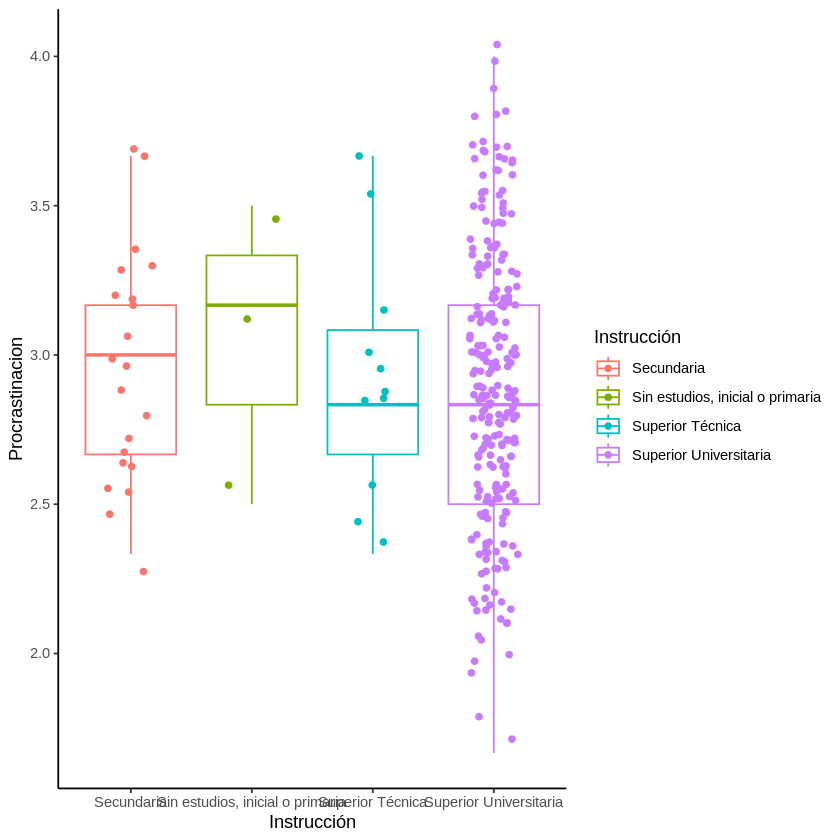

In [97]:
p <- ggplot(df2, aes(x = Instrucción, y = Procrastinacion, color = Instrucción))

p + geom_boxplot() + geom_jitter(width = .2) + theme_classic()

In [98]:
df2 %>%
  anova_test(Procrastinacion ~ Instrucción, detailed = T)

,Effect,SSn,SSd,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,Instrucción,0.136,58.201,3,284,0.222,0.881,,0.002


No se encontraron diferencias significativas en procrastinación global según nivel de instrucción de las y los participantes, F(3,284) = 0.22, p = .88. Este resultado indicaría que la postergación de tareas o el dejar para después las actividades en el día a día no se distingue en función al nivel educativo reportado.

In [99]:
df2 %>%
  tukey_hsd(Procrastinacion ~ Instrucción)

,term,group1,group2,null.value,estimate,conf.low,conf.high,p.adj,p.adj.signif
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,Instrucción,Secundaria,"Sin estudios, inicial o primaria",0,0.10317460,-0.6189084,0.8252576,0.983,ns
2,Instrucción,Secundaria,Superior Técnica,0,-0.02813853,-0.4635709,0.4072939,0.998,ns
3,Instrucción,Secundaria,Superior Universitaria,0,-0.05580651,-0.3214855,0.2098724,0.948,ns
4,Instrucción,"Sin estudios, inicial o primaria",Superior Técnica,0,-0.13131313,-0.8933199,0.6306936,0.970,ns
5,Instrucción,"Sin estudios, inicial o primaria",Superior Universitaria,0,-0.15898112,-0.8384207,0.5204585,0.931,ns
6,Instrucción,Superior Técnica,Superior Universitaria,0,-0.02766798,-0.3879952,0.3326593,0.997,ns
